In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
import cv2
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l, semantic_sam_t
from segment_anything import build_sam
from tree_segmentation import  TreePredictor, TreeSegmentMetric, Tree2D, MaskData
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name
from evaluation.batch_eval_PartNet import get_mesh_and_gt_tree, get_images
import pycocotools.mask as mask_util

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-05 14:47:01.267411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 14:47:02.426317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-05 14:47:02.426443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
utils.set_printoptions(linewidth=120)

2.0.1+cu117


In [3]:
data_root = Path('/data5/SA-1B/')
data_part_1 = data_root.joinpath(f"{0:06d}")
images_paths = list(data_part_1.glob('*.jpg'))
print(f"There are {len(images_paths)} images")
print(len(list(data_part_1.glob('*.json'))))

There are 11186 images
11186


In [4]:
def read_annotations(json_path: Path):
    masks = []
    scores = []
    with open(json_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']
    for ann in annotations:
        scores.append(ann['predicted_iou'])
        masks.append(mask_util.decode(ann['segmentation']))
    scores = np.stack(scores)
    masks = np.stack(masks)
    tree2d = Tree2D(MaskData(masks=torch.from_numpy(masks), iou_preds=torch.from_numpy(scores)))
    tree2d.update_tree()
    return tree2d


# Debug

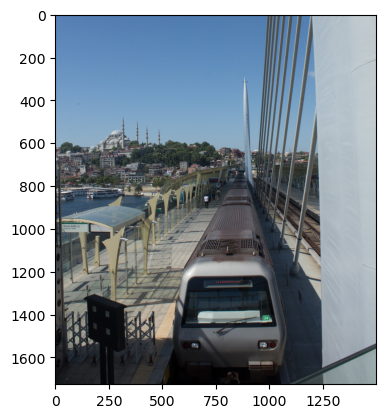

In [28]:
index = 3
image = utils.load_image(images_paths[index])
plt.imshow(image)

0: Tree Root
├── 116
├── 115
├── 114
│   └── 32
├── 113
│   ├── 53
│   └── 110
├── 109
├── 108
├── 106
│   ├── 112
│   │   ├── 46
│   │   ├── 45
│   │   │   └── 42
│   │   └── 38
│   │       ├── 101
│   │       ├── 40
│   │       │   └── 80
│   │       ├── 39
│   │       ├── 2
│   │       └── 16
│   │           └── 57
│   ├── 111
│   │   ├── 104
│   │   └── 43
│   ├── 107
│   │   ├── 62
│   │   └── 60
│   ├── 50
│   │   ├── 67
│   │   └── 61
│   └── 105
│       ├── 35
│       └── 100
├── 103
├── 102
├── 99
│   └── 90
├── 98
├── 97
│   ├── 94
│   └── 96
├── 95
│   ├── 77
│   └── 93
├── 92
├── 91
├── 89
│   └── 71
├── 88
├── 87
├── 86
├── 85
├── 84
├── 83
├── 82
├── 79
├── 78
├── 76
├── 75
├── 72
├── 70
├── 69
├── 68
├── 66
├── 65
├── 64
├── 63
│   └── 81
├── 59
├── 58
│   └── 74
├── 56
├── 55
├── 54
├── 52
├── 51
├── 49
├── 48
├── 47
├── 44
├── 41
├── 37
├── 36
├── 34
├── 33
├── 31
├── 30
├── 29
├── 28
├── 27
├── 26
├── 25
├── 24
├── 23
│   ├── 17
│   │   ├── 73
│   │   └── 21
│   └── 20
│       ├── 22
│       └── 18
├── 19
├── 15
├── 14
├── 13
├── 12
├── 11
├── 10
├── 9
├── 8
│   └── 7
├── 6
├── 5
├── 4
├── 3
└── 1

6

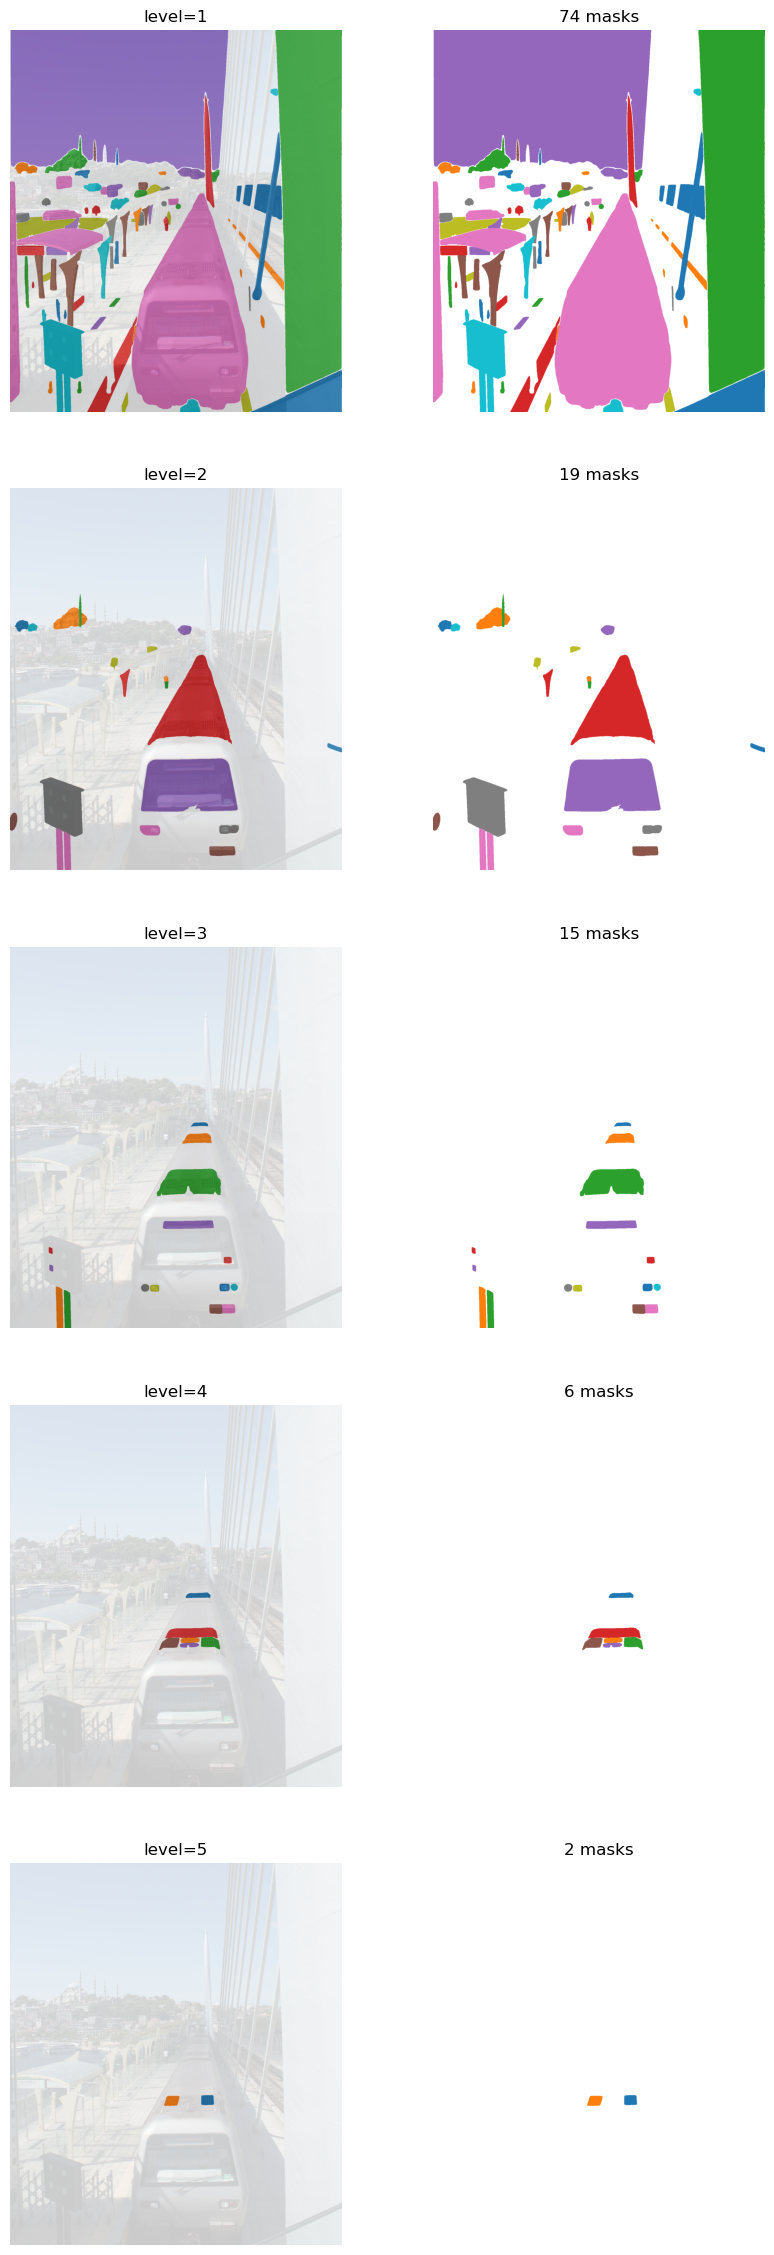

In [29]:
tree2d = read_annotations(images_paths[index].with_suffix('.json'))
tree2d.print_tree()
show_all_levels(image, tree2d, alpha=0.8)

In [30]:
# load SAM
assert torch.cuda.is_available()
# model = build_sam(Path('./weights/sam_vit_h_4b8939.pth').expanduser())
model = semantic_sam_l(Path("./weights/swinl_only_sam_many2many.pth").expanduser())
# model = semantic_sam_t( Path("./weights/swint_only_sam_many2many.pth").expanduser())
model = model.eval().to(device)
tree_seg = TreePredictor(model, box_nms_thresh=0.9)

(1726, 1500, 3)
(1024, 889, 3)
[Tree] reset
[Tree2D] 53 union with [(5, 0.5023499131202698)]
[Tree2D] 100 union with [(52, 0.38509318232536316)]
[Tree2D] 188 union with [(69, 0.4716311991214752)]
[Tree2D] 204 union with [(196, 0.2864019274711609)]
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 213 to 180
[Tree2D] complete init segmentation
[Tree2D] post process min_area=100
[Tree2D] Compress masks
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 180 to 180
[Tree2D] complete post process
[Tree2D] ignore 5/212 masks during generate
feature: 413.ms, points: 0.21ms, decode: 1.91ms, tree: 2.01ms, post:  3s372
{'feature': 0.41356968879699707, 'points': 0.0002162456512451172, 'decode': 1.9612743854522705, 'tree': 2.0681679248809814, 'post': 3.372805118560791}


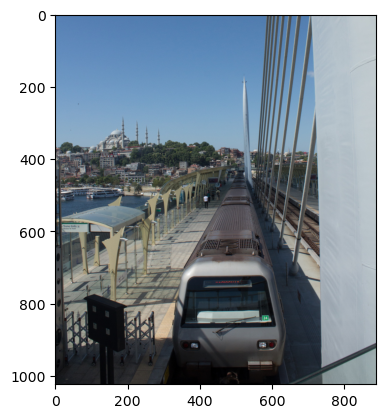

In [43]:
print(image.shape)
H, W, _ = image.shape
scale = min(1024 / H, 1024 / W)
image_resized = cv2.resize(image, (int(scale * W), int(scale * H)), interpolation=cv2.INTER_AREA)
print(image_resized.shape)
plt.imshow(image_resized)
timer = utils.TimeWatcher()
prediction = tree_seg.tree_generate(image_resized, device=device, timer=timer, verbose=1, max_steps=0)
print(timer)
print(timer.sum())

284
[Tree2D] uncompress masks


9

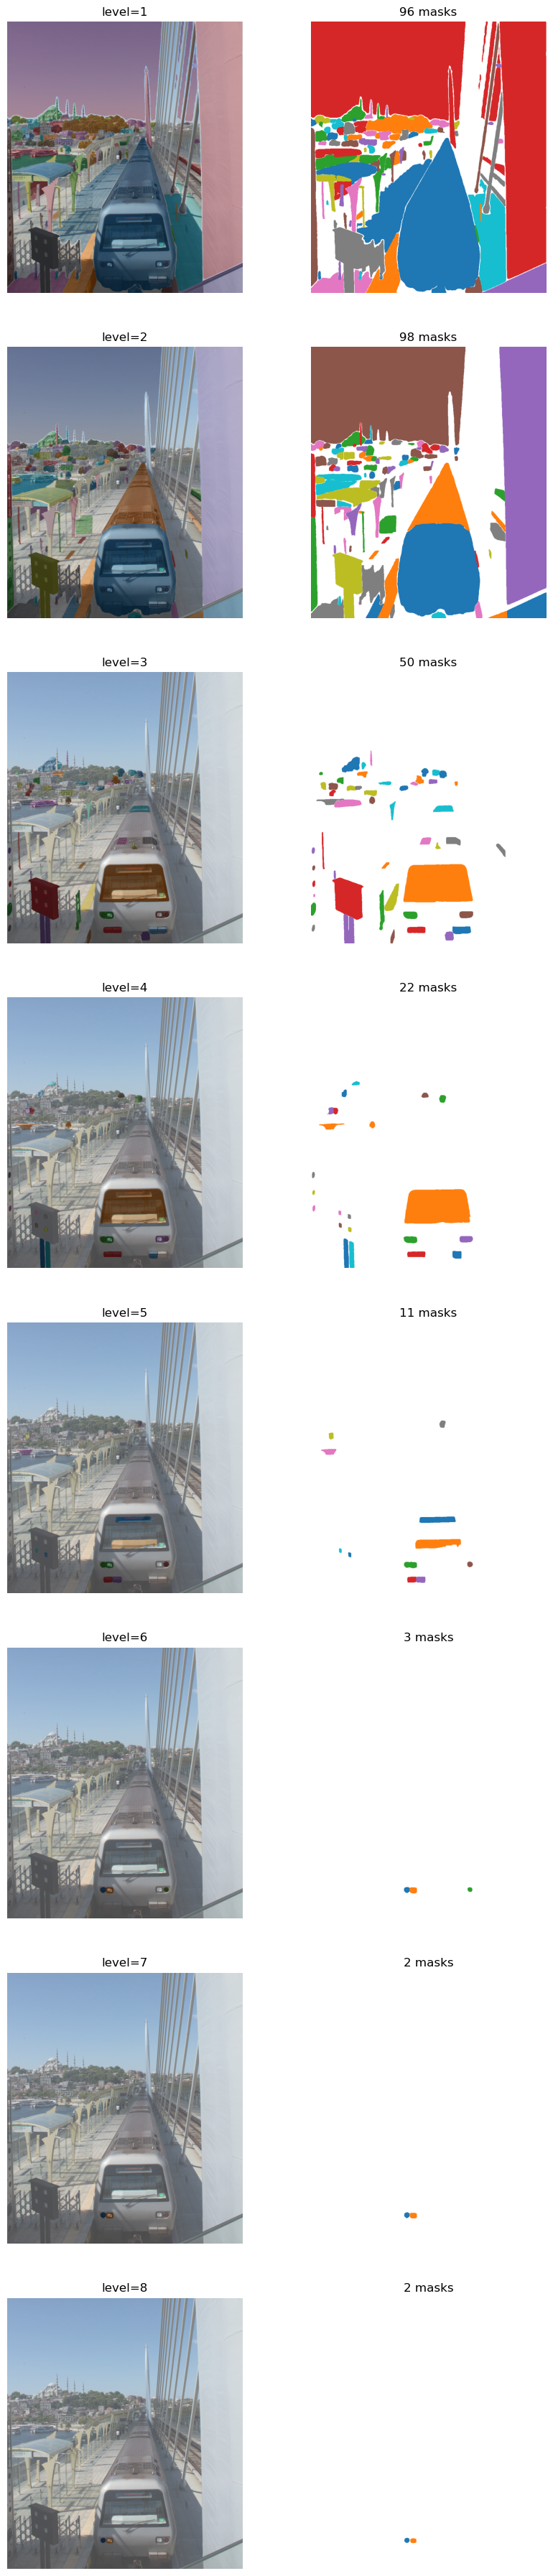

In [37]:
# prediction.print_tree()
print(prediction.num_masks)
show_all_levels(image_resized, prediction)

In [47]:
from tree_segmentation.metric import TreeSegmentMetric
metric = TreeSegmentMetric(is_resize_2d_as_gt=True)
metric.update(prediction.to(device), tree2d.to(device))
for k, v in metric.summarize().items():
    print(k, v)

SQ 0.5640037799703663
RQ 0.7864406779661017
PQ 0.44355551509533897
TS 0.9966013431549072
TQ 0.441268652677536
mSQ 0.9090592265129089
mRQ 0.4358324408531189
mPQ 0.3927081227302551
mTS 0.9979744553565979
mTQ 0.3918329179286957
mIoU 0.4957471191883087


generated
[Tree] reset
[Tree2D] 53 union with [(5, 0.5023499131202698)]
[Tree2D] 100 union with [(52, 0.38509318232536316)]
[Tree2D] 188 union with [(69, 0.4716311991214752)]
[Tree2D] 204 union with [(196, 0.2864019274711609)]
SQ 0.5619371348413927
RQ 0.7864406779661017
PQ 0.4419302212989936
TS 0.9961636066436768
TQ 0.44023481011390686
mSQ 0.9043310284614563
mRQ 0.43564680218696594
mPQ 0.3905128836631775
mTS 0.9976835250854492
mTQ 0.3895126283168793
mIoU 0.49354061484336853


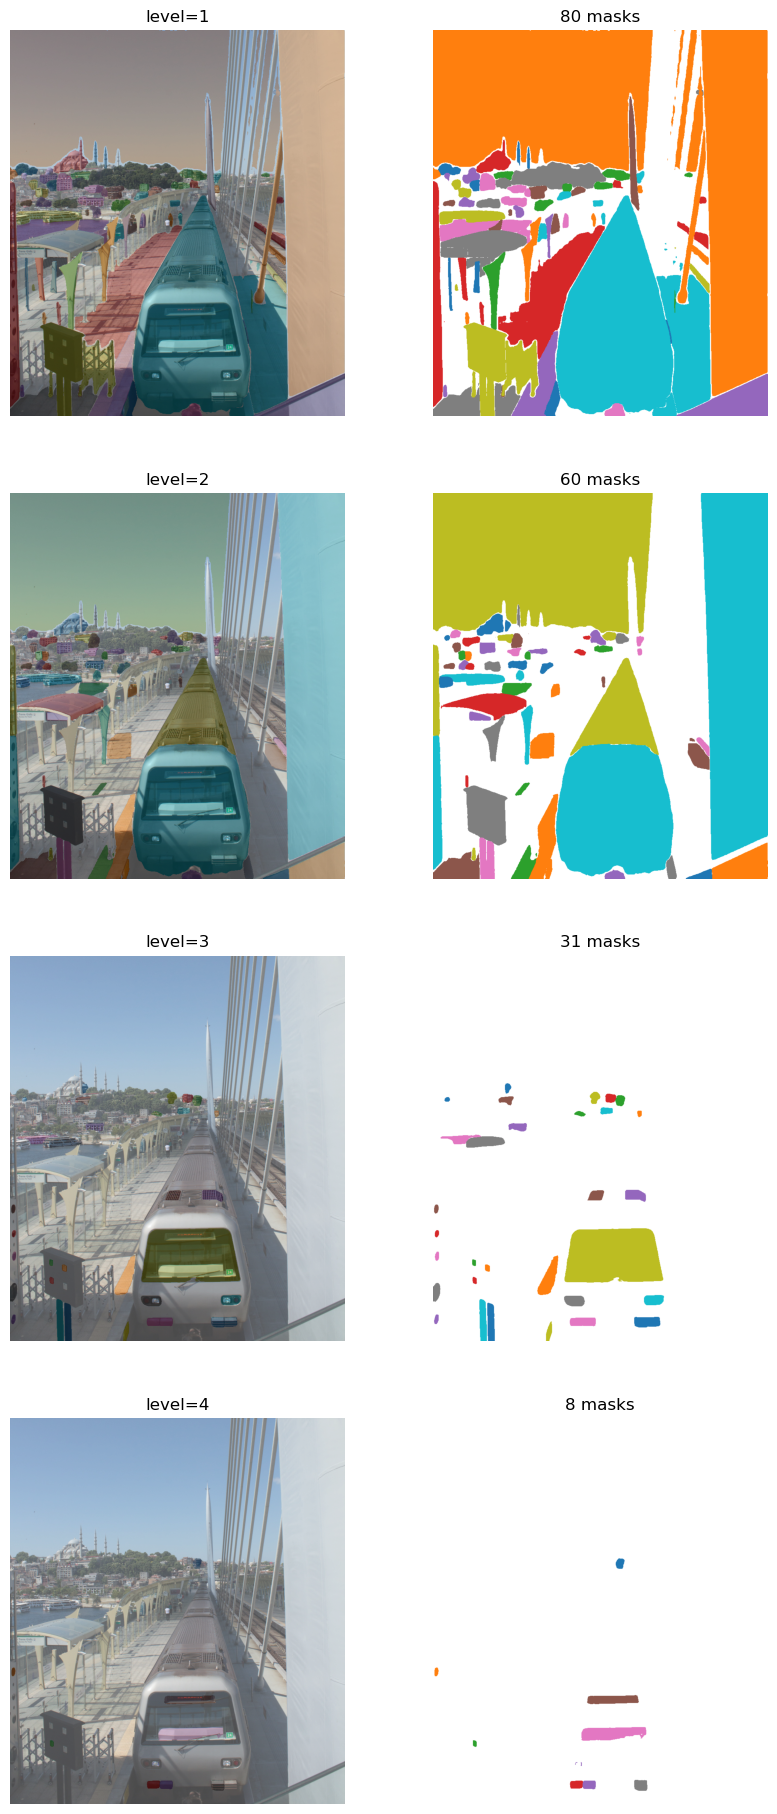

In [39]:
autogen = tree_seg.generate(image_resized)
print('generated')
tree_auto = Tree2D(
    masks=torch.from_numpy(np.stack([s['segmentation'] for s in autogen], axis=0)), 
    scores=torch.tensor([s['predicted_iou'] for s in autogen]),
    device=device,
    verbose=1,
)
tree_auto.update_tree()
show_all_levels(image_resized, tree_auto)

metric = TreeSegmentMetric(is_resize_2d_as_gt=False)
metric.update(tree_auto.to(device), tree2d.to(device))
for k, v in metric.summarize().items():
    print(k, v)

# Evalutate Semantic-SAM-L

In [ ]:
# choose eval images
part_idx = 110 # < 110
num_eval = 10

images_paths =sorted( list(data_root.joinpath(f"{part_idx:06d}").glob('*.jpg')))
np.random.seed(42)
eval_image_paths = np.random.choice(images_paths, num_eval)
print(f"Try To evaluate {len(eval_image_paths)} image")

In [ ]:
# load model
model = semantic_sam_l(Path("./weights/swinl_only_sam_many2many.pth").expanduser())
# model = semantic_sam_t( Path("./weights/swint_only_sam_many2many.pth").expanduser())
model = model.eval().to(device)
tree_seg = TreePredictor(model)
# init metric
metirc = TreeSegmentMetric()

In [ ]:
from tree_segmentation.metric import TreeSegmentMetric
timer = utils.TimeEstimator(num_eval)
time_avg = utils.TimeWatcher()
timer.start()
time_avg.start()
for i, image_path in enumerate(eval_image_paths, 1):
    image = utils.load_image(image_path)
    H, W, _ = image.shape
    scale = min(1024 / H, 1024 / W)
    image = cv2.resize(image, (int(scale * W), int(scale * H)), interpolation=cv2.INTER_AREA)
    time_avg.log('image')
    gt = read_annotations(image_path.with_suffix('.json'))
    time_avg.log('gt')
    prediction = tree_seg.generate(image, device=device)
    time_avg.log('tree2d')
    metirc.update(prediction, gt.to(device), return_match=False)
    time_avg.log('metric')
    timer.step()
    if i % 2 == 0:
        print(f'Process [{i+1}/{num_eval}], time: {timer.progress}',
              ', '.join(f'{k}: {utils.float2str(v)}' for k, v in metirc.summarize().items()))

print('Complete Evalution')
print('Time:', time_avg)
for k, v in metirc.summarize().items():
    print(f"{k:5s}: {v}")